* 개선을 위한 방법
1. 마지막엔 test을 나누지말고 그냥 전부 train 시켜버린다
2. 쓸데 없는 열을 버려본다?
3. 앙상블 모델을 써볼까?

In [1]:
import pandas as pd
import numpy as np
import joblib
import math
from keras.models import load_model

import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

# 1. 데이터 불러오기 및 파악

In [2]:
# 데스크탑
# df = pd.read_csv("C:\\Users\\Hong_PC\\Desktop\\기상청 날씨 빅데이터 공모전\\과제2\\fog_train.csv", index_col=0)

# 노트북
df = pd.read_csv("C:\\Users\\User\\Desktop\\기상청 날씨 빅데이터 공모전\\과제2\\fog_train.csv", index_col=0)

In [3]:
# 열 이름의 . 앞에 단어 제거
df.columns = [col.split('.')[-1] if '.' in col else col for col in df.columns]

In [4]:
# # 시간
# df['year'].value_counts() # 년도
# df['month'].value_counts() # 월
# df['day'].value_counts() # 일
# df['time'].value_counts() # 시간(0~23)
# df['minute'].value_counts() # 분(10분 단위)
# df['stn_id'].value_counts() # 지점 번호

# -99 있음
# df['ws10_deg'].value_counts() # 10분 평균 풍향, 단위 : deg
# df['ws10_ms'].value_counts() # 10분 평균 풍속, 단위 : m/s
# df['ta'].value_counts() # 1분 평균 기온 10분 주기, 단위 : C
# df['re'].value_counts() # 강수 유무(0:무강수, 1:강수)
# df['hm'].value_counts() # 1분 평균 상대 습도 10분 주기, 단위 : %
# df['sun10'].value_counts() # 1분 일사량 10분 단위 합계, 단위 : MJ
# df['ts'].value_counts() # 1분 평균 지면온도 10분 주기, 단위 : C
# df['vis1'].value_counts() # 1분 평균 시정 10분 주기, 단위 : C(test데이터 셋엔 없음)
# df['class'].value_counts() # 시정 구간

# 파생변수

# 2. 문자열 데이터 정리

## 2-1. year열 I,J,K 순으로 0,1,2로 맵핑

In [5]:
# year열 I,J,K 순으로 0,1,2로 맵핑
df['year'].value_counts()
df['year'] = df['year'].map({'I': 0, 'J': 1, 'K': 2})

## 2-2. 20개 지점을 5개의 지역으로 수치화

In [6]:
# region는 stn_id에서 앞글자만 가져오고 숫자화
df['region'] = df['stn_id'].str[0]
# 알파벳 순서에 따라 번호를 부여
alphabet_order = {char: idx for idx, char in enumerate(sorted(df['region'].unique()))}
df['region'] = df['region'].map(alphabet_order)

# stn_id를 숫자화
# 원하는 순서대로 레이블을 숫자로 매핑하는 딕셔너리 생성
stn_id_mapping = {v: k for k, v in enumerate(['AA', 'AB', 'AC', 'AD', 'AE', 'AF', 'AG', 'AH', 
                                              'BA', 'BB', 'BC', 'BD', 'CA', 'CB', 'DA', 'DB', 
                                              'DC', 'EA', 'EB', 'EC'])}
# stn_id 열에 대해 딕셔너리를 적용하여 숫자로 변환
df['stn_id'] = df['stn_id'].map(stn_id_mapping)

In [7]:
df_B = df[df['region'] == 1].reset_index(drop=True)

In [8]:
df= df_B.copy()

# 3. 독립변수 결측치 처리

In [9]:
df

,year,month,day,time,minute,stn_id,ws10_deg,ws10_ms,ta,re,hm,sun10,ts,vis1,class,region
0,0,1,1,0,10,8,270.4,1.9,-7.5,0.0,59.3,0.0,-99.9,18800,4,1
1,0,1,1,0,20,8,263.0,2.3,-7.5,0.0,59.1,0.0,-99.9,18700,4,1
2,0,1,1,0,30,8,262.2,2.8,-7.5,0.0,58.7,0.0,-99.9,19916,4,1
3,0,1,1,0,40,8,274.3,3.0,-7.5,0.0,57.6,0.0,-99.9,20816,4,1
4,0,1,1,0,50,8,274.6,3.2,-7.6,0.0,57.8,0.0,-99.9,20283,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
631287,2,12,31,23,10,11,269.9,7.2,-4.5,0.0,66.0,0.0,-99.9,15830,4,1
631288,2,12,31,23,20,11,266.2,7.6,-4.5,0.0,66.4,0.0,-99.9,15632,4,1
631289,2,12,31,23,30,11,271.1,7.5,-4.5,0.0,66.7,0.0,-99.9,15388,4,1
631290,2,12,31,23,40,11,268.9,7.0,-4.5,0.0,66.5,0.0,-99.9,15376,4,1


In [10]:
# 수정(ta-ts계산)

# 변환할 열 리스트
na_cols = ['ws10_deg', 'ws10_ms', 'ta', 're', 'hm', 'sun10', 'ts']

# -99.9 값을 NaN으로 변환
df[na_cols] = df[na_cols].replace(-99.9, np.nan)
'''
# ts와 ta의 차이의 평균 계산
average_difference = (df['ta'] - df['ts']).mean()

# ts와 ta 중 하나라도 값이 있는 경우 평균 차이를 이용하여 채우기
df['ts'] = np.where(pd.isna(df['ts']) & pd.notna(df['ta']), df['ta'] - average_difference, df['ts'])
df['ta'] = np.where(pd.isna(df['ta']) & pd.notna(df['ts']), df['ts'] + average_difference, df['ta'])
'''
numeric_cols = ['ws10_deg', 'ws10_ms', 'ta', 'hm', 'sun10', 'ts']
# 선형보간법을 이용하여 NA값 처리
df[numeric_cols] = df[numeric_cols].interpolate(method='linear')
df[numeric_cols] = df[numeric_cols].interpolate(method='bfill') # 그럼에도 na가 남아있으면


# 강수 유무에 대해선 전의 값으로 채움
df['re'] = df['re'].interpolate(method='ffill')

print(df.isnull().sum())

year        0
month       0
day         0
time        0
minute      0
stn_id      0
ws10_deg    0
ws10_ms     0
ta          0
re          0
hm          0
sun10       0
ts          0
vis1        0
class       0
region      0
dtype: int64


# 4. 이상치 처리

In [11]:
# 인덱스 안쓰는 방식으로 수정
features = df.columns.difference(['year', 'month', 'day', 'time','minute', 'stn_id', 're', 'vis1', 'class','region'])

# 이상치 탐지 함수
def detect_outliers(df, features):
    for feature in features:
        data = df[feature]
        mean = data.mean()
        std = data.std()
        ucl = mean + 3 * std
        lcl = mean - 3 * std
        outliers = (data > ucl) | (data < lcl)
        df.loc[outliers, feature] = np.nan
        df[feature] = df[feature].interpolate(method='linear')  # 선형보간법
        # method='ffill', 'bfill'쓰면 직전 값, 직후 값으로 대체 가능
        # .interpolate(method='polynomial', order=2) # 2차 다항식 보간법
        # .interpolate(method='linear') # 선형보간법
    return df

df = detect_outliers(df,features)

# 6. class 결측치 채우기

**파생변수**

In [12]:
# 모델 돌리기 위해 계절별 MINMAX를 해야함
# 그럴라면 파생변수 season이 필요

# 계절(봄 : 0, 여름 : 1, 가을 : 2, 겨울 : 3)
# 계절을 매핑하는 함수
def map_season(month):
    if month in [3, 4, 5]:
        return 0  # 봄
    elif month in [6, 7, 8]:
        return 1  # 여름
    elif month in [9, 10, 11]:
        return 2  # 가을
    else:
        return 3  # 겨울

df['season'] = df['month'].apply(map_season)


## 6-1. xgr를 활용하여 vis1 결측값 예측한 후, 해당 예측값을 결측값을 대체

In [13]:
df

,year,month,day,time,minute,stn_id,ws10_deg,ws10_ms,ta,re,hm,sun10,ts,vis1,class,region,season
0,0,1,1,0,10,8,270.4,1.9,-7.5,0.0,59.3,0.0,-4.8,18800,4,1,3
1,0,1,1,0,20,8,263.0,2.3,-7.5,0.0,59.1,0.0,-4.8,18700,4,1,3
2,0,1,1,0,30,8,262.2,2.8,-7.5,0.0,58.7,0.0,-4.8,19916,4,1,3
3,0,1,1,0,40,8,274.3,3.0,-7.5,0.0,57.6,0.0,-4.8,20816,4,1,3
4,0,1,1,0,50,8,274.6,3.2,-7.6,0.0,57.8,0.0,-4.8,20283,4,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
631287,2,12,31,23,10,11,269.9,7.2,-4.5,0.0,66.0,0.0,-4.9,15830,4,1,3
631288,2,12,31,23,20,11,266.2,7.6,-4.5,0.0,66.4,0.0,-4.9,15632,4,1,3
631289,2,12,31,23,30,11,271.1,7.5,-4.5,0.0,66.7,0.0,-4.9,15388,4,1,3
631290,2,12,31,23,40,11,268.9,7.0,-4.5,0.0,66.5,0.0,-4.9,15376,4,1,3


In [14]:
# df_xgr 데이터프레임을 복사하여 사용합니다. 'class'는 초기에 'XGR'로 채워져 있다고 가정합니다.
df_xgr = df.copy()

# 클래스 분포를 확인하는 함수를 정의합니다.
def count_classes(df):
    return df['class'].value_counts()

In [15]:
# 초기 클래스 분포를 저장합니다.
initial_class_counts = count_classes(df_xgr)

# 'vis1'이 결측치가 아닌 행과 결측치인 행을 구분합니다.
train_data = df_xgr[df_xgr['vis1'] != -99]
test_data = df_xgr[df_xgr['vis1'] == -99]

# 'vis1'과 'class'를 제외한 열을 feature로 선택합니다.
features = df_xgr.columns.difference(['vis1', 'class'])

# train 데이터의 feature와 target을 분리합니다.
X_train = train_data[features]
y_train = train_data['vis1']

# test 데이터의 feature를 선택합니다.
X_test = test_data[features]

In [16]:
# 실제 수치형 데이터만 포함하는 리스트를 생성합니다.
numeric_features = ['ws10_deg', 'ws10_ms', 'ta', 'hm', 'sun10', 'ts']
# 계절을 반영한 MINMAX 스케일러 객체를 생성합니다.
minmax_scaler = MinMaxScaler()

# train 데이터를 기반으로 스케일러를 학습하고, train과 test 데이터 모두에 스케일링을 적용합니다.
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

# 'season' 열을 기반으로 각 계절에 따라 스케일링을 적용합니다.
for season_value in range(4):  # 계절은 0부터 3까지의 값이 있습니다.
    train_mask = X_train_scaled['season'] == season_value
    test_mask = X_test_scaled['season'] == season_value
    if train_mask.sum() > 0:
        X_train_scaled.loc[train_mask, numeric_features] = minmax_scaler.fit_transform(X_train_scaled.loc[train_mask, numeric_features])
    if test_mask.sum() > 0:
        X_test_scaled.loc[test_mask, numeric_features] = minmax_scaler.transform(X_test_scaled.loc[test_mask, numeric_features])

In [17]:
# XGBoost 회귀 모델을 학습하고 예측합니다.
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=123)
xgb_model.fit(X_train_scaled, y_train)
y_pred = xgb_model.predict(X_test_scaled)

# 예측된 값으로 test 데이터의 'vis1'의 결측치를 대체합니다.
test_data.loc[test_data['vis1'] == -99, 'vis1'] = y_pred[test_data['vis1'] == -99]

# 'vis1' 값을 기반으로 'class'를 분류하는 함수를 정의합니다.
def classify_visibility(vis1):
    if vis1 < 200:
        return 1
    elif vis1 < 500:
        return 2
    elif vis1 < 1000:
        return 3
    else:
        return 4

# test 데이터에 대해 'class' 값을 예측합니다.
test_data.loc[test_data['class'] == -99, 'class'] = test_data.loc[test_data['class'] == -99, 'vis1'].apply(classify_visibility)

C:\Users\User\AppData\Local\Temp\ipykernel_22484\1451596185.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.loc[test_data['vis1'] == -99, 'vis1'] = y_pred[test_data['vis1'] == -99]
C:\Users\User\AppData\Local\Temp\ipykernel_22484\1451596185.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.loc[test_data['class'] == -99, 'class'] = test_data.loc[test_data['class'] == -99, 'vis1'].apply(classify_visibility)


In [18]:
# 전체 데이터프레임에 test 데이터의 변경 사항을 반영합니다.
df_xgr.update(test_data)

# 예측된 'vis1' 값을 기반으로 한 최종 'class' 분포를 계산합니다.
final_class_counts = count_classes(df_xgr)

# 초기 클래스 분포와 최종 클래스 분포를 계산하여 출력합니다.
print("초기 클래스 분포:\n", initial_class_counts)
print("최종 클래스 분포:\n", final_class_counts)

# 예측된 클래스 분포를 시각화합니다.
df_pred_class = pd.DataFrame({'y_pred': y_pred})
df_pred_class['pred_class'] = df_pred_class['y_pred'].apply(classify_visibility)

초기 클래스 분포:
  4     613841
 2       6538
 3       4393
-99      3281
 1       3239
Name: class, dtype: int64
최종 클래스 분포:
 4.0    617117
2.0      6538
3.0      4394
1.0      3243
Name: class, dtype: int64


c:\Users\User\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 50696 (\N{HANGUL SYLLABLE YE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\User\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 52769 (\N{HANGUL SYLLABLE CEUG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\User\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 46108 (\N{HANGUL SYLLABLE DOEN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\User\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 53364 (\N{HANGUL SYLLABLE KEUL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\User\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 47000 (\N{HANGUL SYLLABLE RAE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\User\anaconda3\lib\

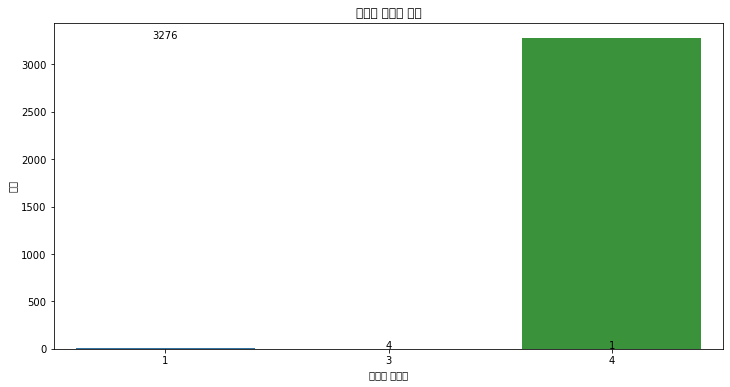

In [19]:
# 예측된 클래스 분포를 막대 그래프로 나타냅니다.
plt.figure(figsize=(12, 6))
sns.barplot(x=df_pred_class['pred_class'].value_counts().index, y=df_pred_class['pred_class'].value_counts().values)
plt.title('예측된 클래스 분포')
plt.xlabel('예측된 클래스')
plt.ylabel('개수')

# 막대 위에 숫자를 표시합니다.
for index, value in enumerate(df_pred_class['pred_class'].value_counts().values):
    plt.text(index, value + 0.05, str(value), ha='center')

plt.show()

In [20]:
# vis1 20000이상인 값은 20000으로 변경
df_xgr.loc[df_xgr['vis1'] >= 20000.0, 'vis1'] = 20000.0
df_xgr.loc[df_xgr['vis1'] <= 0.0, 'vis1'] = 0.0

## 6-2. 완성된 데이터 셋 저장

In [21]:
# xgr

# 노트북
# joblib.dump(df_xgr, 'C:\\Users\\User\\Desktop\\기상청 날씨 빅데이터 공모전\\과제2\\df_xgr.pkl')

# 데스크탑
# joblib.dump(df_xgr, "C:\\Users\\Hong_PC\\Desktop\\기상청 날씨 빅데이터 공모전\\과제2\\df_xgr.pkl")

# 7. VIS1 예측(회귀)

In [22]:
df = df_xgr.copy()

In [23]:
df['vis1'].value_counts()

20000.000000    297301
16100.000000       444
15100.000000       439
13000.000000       432
13800.000000       430
                 ...  
9097.520508          1
11519.554688         1
12089.023438         1
10076.956055         1
14208.876953         1
Name: vis1, Length: 21714, dtype: int64

In [24]:
print(df[(df['vis1']!='20000.0')].shape)
print(df[(df['vis1']=='20000.0')].shape)

(631292, 17)
(0, 17)


**파생변수** 

In [25]:
df

,year,month,day,time,minute,stn_id,ws10_deg,ws10_ms,ta,re,hm,sun10,ts,vis1,class,region,season
0,0.0,1.0,1.0,0.0,10.0,8.0,270.4,1.9,-7.5,0.0,59.3,0.0,-4.8,18800.0,4.0,1.0,3.0
1,0.0,1.0,1.0,0.0,20.0,8.0,263.0,2.3,-7.5,0.0,59.1,0.0,-4.8,18700.0,4.0,1.0,3.0
2,0.0,1.0,1.0,0.0,30.0,8.0,262.2,2.8,-7.5,0.0,58.7,0.0,-4.8,19916.0,4.0,1.0,3.0
3,0.0,1.0,1.0,0.0,40.0,8.0,274.3,3.0,-7.5,0.0,57.6,0.0,-4.8,20000.0,4.0,1.0,3.0
4,0.0,1.0,1.0,0.0,50.0,8.0,274.6,3.2,-7.6,0.0,57.8,0.0,-4.8,20000.0,4.0,1.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
631287,2.0,12.0,31.0,23.0,10.0,11.0,269.9,7.2,-4.5,0.0,66.0,0.0,-4.9,15830.0,4.0,1.0,3.0
631288,2.0,12.0,31.0,23.0,20.0,11.0,266.2,7.6,-4.5,0.0,66.4,0.0,-4.9,15632.0,4.0,1.0,3.0
631289,2.0,12.0,31.0,23.0,30.0,11.0,271.1,7.5,-4.5,0.0,66.7,0.0,-4.9,15388.0,4.0,1.0,3.0
631290,2.0,12.0,31.0,23.0,40.0,11.0,268.9,7.0,-4.5,0.0,66.5,0.0,-4.9,15376.0,4.0,1.0,3.0


In [26]:
# 계절(봄 : 0, 여름 : 1, 가을 : 2, 겨울 : 3)
# 계절을 매핑하는 함수
def map_season(month):
    if month in [3, 4, 5]:
        return 0  # 봄
    elif month in [6, 7, 8]:
        return 1  # 여름
    elif month in [9, 10, 11]:
        return 2  # 가을
    else:
        return 3  # 겨울

df['season'] = df['month'].apply(map_season)

In [27]:
# 이슬점(dew_point)
# 이슬점 계산 함수
def calculate_dew_point(temp_celsius, relative_humidity):
    a = 17.27
    b = 237.7
    # 상대 습도가 0이면 매우 낮은 값을 설정하여 log(0)가 발생하지 않도록 한다.
    rh = max(relative_humidity / 100.0, 1e-6)
    alpha = ((a * temp_celsius) / (b + temp_celsius)) + math.log(rh)
    dew_point = (b * alpha) / (a - alpha)
    return dew_point

# 이슬점 계산하여 새로운 열 추가
df['dew_point'] = df.apply(lambda row: calculate_dew_point(row['ta'], row['hm']), axis=1)

In [28]:
# 풍향
# 풍향을 16방위로 변환하는 함수
def convert_wind_direction(wind_dir):
    # 22.5도 간격으로 16방위로 매핑
    direction = int((wind_dir + 11.25) % 360 / 22.5)
    return direction

# 풍향을 16방위로 변환하여 새로운 열에 추가
df['ws10_deg_16'] = df['ws10_deg'].apply(convert_wind_direction)


In [29]:
# 일교차(diurnal_range)
# 날짜(year, month, day), 관측 장소(stn_id)로 그룹화하여 일교차 계산
df['diurnal_range'] = df.groupby(['year', 'month', 'day', 'stn_id'])['ts'].transform(lambda x: x.max() - x.min())

In [30]:
# 기온-이슬점(안개형성조건, 기온이 이슬점 이하일 때 잘 발생)
df['ts_dew_diff'] = df['ts'] - df['dew_point']

In [31]:
# 50분 이동평균(습도)
def calculate_rolling_mean(group):
    group['5_hm'] = group['hm'].rolling(window=5).mean()
    group['5_hm'] = group['5_hm'].fillna(group['hm'])
    return group

# 각 stn_id별로 그룹화하여 함수 적용
df = df.groupby('stn_id', group_keys=False).apply(calculate_rolling_mean)

In [32]:
# 필요 없는 열 제거(시간 디테일 지역이라던가)

In [33]:
df_pluscol = df.copy()

## 8-1. LSTM-1(양방향)

In [34]:
df = df_pluscol.copy()

In [35]:
df.columns

Index(['year', 'month', 'day', 'time', 'minute', 'stn_id', 'ws10_deg',
       'ws10_ms', 'ta', 're', 'hm', 'sun10', 'ts', 'vis1', 'class', 'region',
       'season', 'dew_point', 'ws10_deg_16', 'diurnal_range', 'ts_dew_diff',
       '5_hm'],
      dtype='object')

In [36]:
df

,year,month,day,time,minute,stn_id,ws10_deg,ws10_ms,ta,re,...,ts,vis1,class,region,season,dew_point,ws10_deg_16,diurnal_range,ts_dew_diff,5_hm
0,0.0,1.0,1.0,0.0,10.0,8.0,270.4,1.9,-7.5,0.0,...,-4.8,18800.0,4.0,1.0,3,-14.053639,12,9.8,9.253639,59.30
1,0.0,1.0,1.0,0.0,20.0,8.0,263.0,2.3,-7.5,0.0,...,-4.8,18700.0,4.0,1.0,3,-14.094795,12,9.8,9.294795,59.10
2,0.0,1.0,1.0,0.0,30.0,8.0,262.2,2.8,-7.5,0.0,...,-4.8,19916.0,4.0,1.0,3,-14.177480,12,9.8,9.377480,58.70
3,0.0,1.0,1.0,0.0,40.0,8.0,274.3,3.0,-7.5,0.0,...,-4.8,20000.0,4.0,1.0,3,-14.407481,12,9.8,9.607481,57.60
4,0.0,1.0,1.0,0.0,50.0,8.0,274.6,3.2,-7.6,0.0,...,-4.8,20000.0,4.0,1.0,3,-14.459499,12,9.8,9.659499,58.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
631287,2.0,12.0,31.0,23.0,10.0,11.0,269.9,7.2,-4.5,0.0,...,-4.9,15830.0,4.0,1.0,3,-9.877626,12,5.5,4.977626,66.36
631288,2.0,12.0,31.0,23.0,20.0,11.0,266.2,7.6,-4.5,0.0,...,-4.9,15632.0,4.0,1.0,3,-9.801203,12,5.5,4.901203,66.20
631289,2.0,12.0,31.0,23.0,30.0,11.0,271.1,7.5,-4.5,0.0,...,-4.9,15388.0,4.0,1.0,3,-9.744155,12,5.5,4.844155,66.12
631290,2.0,12.0,31.0,23.0,40.0,11.0,268.9,7.0,-4.5,0.0,...,-4.9,15376.0,4.0,1.0,3,-9.782162,12,5.5,4.882162,66.20


In [37]:
# 필요한 열만 사용
numeric_features = ['ws10_deg', 'ws10_ms', 'ta', 'hm', 'sun10', 'ts',
                    'dew_point', 'diurnal_range', '5_hm']
categorical_features = ['region', 'season', 're', 'ws10_deg_16']
target = 'vis1'

# 데이터프레임에서 필요한 열만 선택
data = df[numeric_features + categorical_features + [target]]

In [38]:
# # 원핫인코딩 안함 너무 오래 걸려 -> 라벨 인코딩으로
# # 인덱스를 확인하기 위해 원본 데이터프레임의 인덱스를 저장합니다.
# original_indices = data.index
# # 원핫 인코딩을 위한 OneHotEncoder 객체 생성
# onehot_encoder = OneHotEncoder(sparse=False)
# # 카테고리형 변수에 대해 원핫 인코딩을 적용
# encoded_categorical_data = onehot_encoder.fit_transform(data[categorical_features])
# # 원핫 인코딩된 결과를 데이터프레임으로 변환
# encoded_categorical_df = pd.DataFrame(encoded_categorical_data, columns=onehot_encoder.get_feature_names_out(categorical_features))

In [39]:
# 일단 생략
'''
# 인덱스를 확인하기 위해 원본 데이터프레임의 인덱스를 저장합니다.
original_indices = data.index
# 라벨 인코딩을 위한 LabelEncoder 객체 생성
label_encoders = {feature: LabelEncoder() for feature in categorical_features}
# 카테고리형 변수에 대해 라벨 인코딩을 적용
encoded_categorical_data = data[categorical_features].apply(lambda x: label_encoders[x.name].fit_transform(x))
# 인코딩된 카테고리형 변수와 원본 데이터프레임을 합침
processed_data = pd.concat([data[numeric_features], encoded_categorical_data, data[target]], axis=1)
'''

'\n# 인덱스를 확인하기 위해 원본 데이터프레임의 인덱스를 저장합니다.\noriginal_indices = data.index\n# 라벨 인코딩을 위한 LabelEncoder 객체 생성\nlabel_encoders = {feature: LabelEncoder() for feature in categorical_features}\n# 카테고리형 변수에 대해 라벨 인코딩을 적용\nencoded_categorical_data = data[categorical_features].apply(lambda x: label_encoders[x.name].fit_transform(x))\n# 인코딩된 카테고리형 변수와 원본 데이터프레임을 합침\nprocessed_data = pd.concat([data[numeric_features], encoded_categorical_data, data[target]], axis=1)\n'

In [40]:
# 계절을 반영한 Min-Max 스케일링
scaler = MinMaxScaler()
scaled_numeric_data = data.copy()

# 'season' 열을 기반으로 각 계절에 따라 스케일링을 적용
for season_value in range(4):  # 계절은 0부터 3까지의 값이 있습니다.
    mask = scaled_numeric_data['season'] == season_value
    if mask.sum() > 0:
        scaled_numeric_data.loc[mask, numeric_features] = scaler.fit_transform(scaled_numeric_data.loc[mask, numeric_features])

# 숫자형 변수와 원본 카테고리형 변수를 합침
processed_data = pd.concat([scaled_numeric_data[numeric_features], data[categorical_features], data[target]], axis=1)

In [41]:
processed_data.iloc[111111:111119]

,ws10_deg,ws10_ms,ta,hm,sun10,ts,dew_point,diurnal_range,5_hm,region,season,re,ws10_deg_16,vis1
111111,0.773889,0.475610,0.595937,0.227712,0.551724,0.478589,0.463694,0.527911,0.225269,1.0,3,0.0,12,20000.0
111112,0.778611,0.536585,0.595937,0.241676,0.534483,0.463476,0.475809,0.527911,0.219127,1.0,3,0.0,12,20000.0
111113,0.800000,0.487805,0.595937,0.241676,0.482759,0.450882,0.475809,0.527911,0.218908,1.0,3,0.0,13,20000.0
111114,0.753611,0.378049,0.604966,0.245972,0.465517,0.438287,0.486668,0.527911,0.223295,1.0,3,0.0,12,20000.0
111115,0.710556,0.463415,0.595937,0.241676,0.431034,0.410579,0.475809,0.527911,0.223733,1.0,3,0.0,11,20000.0
111116,0.760833,0.463415,0.604966,0.240602,0.396552,0.395466,0.482112,0.527911,0.226365,1.0,3,0.0,12,20000.0
111117,0.746111,0.487805,0.602709,0.238453,0.362069,0.370277,0.478467,0.527911,0.225707,1.0,3,0.0,12,20000.0
111118,0.730833,0.451220,0.602709,0.229860,0.344828,0.347607,0.470983,0.527911,0.223295,1.0,3,0.0,12,20000.0


In [42]:
# 시계열 데이터 생성
sequence_length = 6

def create_sequences(data, sequence_length):
    sequences = []
    labels = []
    for i in range(len(data) - sequence_length):
        seq = data.iloc[i:i + sequence_length].drop(columns=[target])
        label = data.iloc[i + sequence_length][target]
        sequences.append(seq.values)
        labels.append(label)
    return np.array(sequences), np.array(labels)

sequences, labels = create_sequences(processed_data, sequence_length)

# 학습 데이터와 테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(sequences, labels, test_size=0.2, random_state=123)


In [43]:
# 양방향 LSTM 모델 구성
model = Sequential()
model.add(Bidirectional(LSTM(50, return_sequences=True), input_shape=(sequence_length, X_train.shape[-1])))
model.add(Dropout(0.2))  # Dropout 추가
model.add(Bidirectional(LSTM(50)))
model.add(Dropout(0.2))  # Dropout 추가
model.add(Dense(1, activation='linear'))

model.compile(optimizer='adam', loss='mse')

# Early Stopping 콜백 설정
early_stopping = EarlyStopping(monitor='val_loss', 
                               patience=3, 
                               verbose=1, # 로그출력
                               restore_best_weights=True)

# 모델 학습
history = model.fit(X_train, y_train, validation_split=0.2, epochs=3, batch_size=64, callbacks=[early_stopping]) # 20정도면 충분하긴함

Epoch 1/3
6313/6313 [==============================] - 112s 17ms/step - loss: 261614640.0000 - val_loss: 252667104.0000
Epoch 2/3
6313/6313 [==============================] - 116s 18ms/step - loss: 243060848.0000 - val_loss: 234500656.0000
Epoch 3/3
6313/6313 [==============================] - 104s 16ms/step - loss: 225325120.0000 - val_loss: 217140736.0000


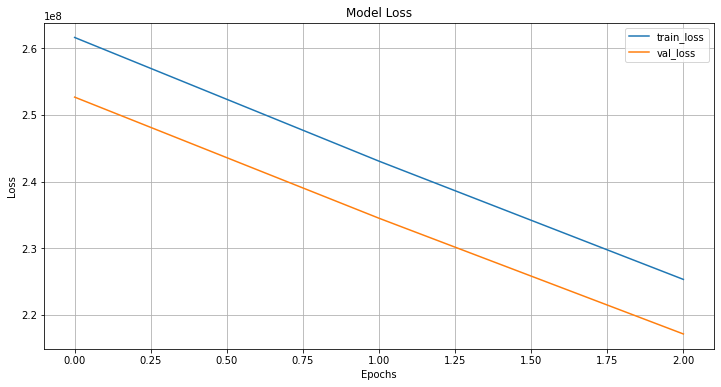

In [44]:
# history 그래프로 시각화
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [45]:
# 모델 평가
y_pred = model.predict(X_test)

3946/3946 [==============================] - 17s 4ms/step


In [46]:
# 예측된 vis1을 바탕으로 class를 계산
def classify_vis1(vis1):
    if vis1 < 200:
        return 1
    elif vis1 < 500:
        return 2
    elif vis1 < 1000:
        return 3
    else:
        return 4

y_pred_class = np.array([classify_vis1(vis) for vis in y_pred.flatten()])
y_test_class = np.array([classify_vis1(vis) for vis in y_test])

In [47]:
# CSI 계산 예시 (필요에 따라 추가적으로 수행)
def calculate_csi(y_true, y_pred):
    confusion = confusion_matrix(y_true, y_pred)
    csi_values = []
    for i in range(1, 5):  # class 1 to 4
        tp = np.sum((y_true == i) & (y_pred == i))
        fp = np.sum((y_true != i) & (y_pred == i))
        fn = np.sum((y_true == i) & (y_pred != i))
        csi = tp / (tp + fp + fn) if (tp + fp + fn) > 0 else 0
        csi_values.append(csi)
    return np.mean(csi_values)

csi = calculate_csi(y_test_class, y_pred_class)
print(f'CSI: {csi}')

CSI: 0.24443203598979868


In [48]:
# #모델 저장
model.save('model_B.h5')

# # 노트북
# model.save('C:\\Users\\User\\Desktop\\기상청 날씨 빅데이터 공모전\\과제2\\model_1.h5')

# 데스크탑
# model.save('C:\\Users\\Hong_PC\\Desktop\\기상청 날씨 빅데이터 공모전\\과제2\\model_1.h5')

c:\Users\User\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [49]:
# # 전처리기 저장
joblib.dump(scaler, 'scaler_B.pkl')
# joblib.dump(label_encoders, 'label_encoders_B.pkl')

# # 노트북
# joblib.dump(scaler, 'C:\\Users\\User\\Desktop\\기상청 날씨 빅데이터 공모전\\과제2\\scaler_1.pkl')
# joblib.dump(label_encoders, 'C:\\Users\\User\\Desktop\\기상청 날씨 빅데이터 공모전\\과제2\\label_encoders_1.pkl')

# # 데스크탑
# joblib.dump(scaler, 'C:\\Users\\Hong_PC\\Desktop\\기상청 날씨 빅데이터 공모전\\과제2\\scaler.pkl')
# joblib.dump(label_encoders, 'C:\\Users\\Hong_PC\\Desktop\\기상청 날씨 빅데이터 공모전\\과제2\\label_encoders.pkl')

['scaler_B.pkl']

### fog_test.csv을 예측 

In [50]:
# 데스크탑
# df_test = pd.read_csv("C:\\Users\\Hong_PC\\Desktop\\기상청 날씨 빅데이터 공모전\\과제2\\fog_test.csv", index_col=0)

# 노트북
df_test = pd.read_csv("C:\\Users\\User\\Desktop\\기상청 날씨 빅데이터 공모전\\과제2\\fog_test.csv", index_col=0)

In [51]:
df_original = df_test.copy()
df = df_test.copy()

**기본 전처리**

In [52]:
# 열 이름의 . 앞에 단어 제거
df.columns = [col.split('.')[-1] if '.' in col else col for col in df.columns]

# year열 I, J, K 순으로 0, 1, 2로 맵핑 (현재 L만 있어서 0으로 맵핑)
df['year'] = df['year'].map({'L': 0})

# region는 stn_id에서 앞글자만 가져오고 숫자화
df['region'] = df['stn_id'].str[0]
alphabet_order = {char: idx for idx, char in enumerate(sorted(df['region'].unique()))}
df['region'] = df['region'].map(alphabet_order)

# stn_id를 숫자화
stn_id_mapping = {v: k for k, v in enumerate(['AI', 'BE', 'CC', 'DD'])}
df['stn_id'] = df['stn_id'].map(stn_id_mapping)

In [53]:
# 마지막 행이 결측열이길래 제거
df.loc[:, df.columns != 'class'] = df.loc[:, df.columns != 'class'].fillna(method='ffill')

In [54]:
df_test_B = df[df['region'] == 1]

In [55]:
df= df_test_B.copy()

**결측치 제거**

In [56]:
# df에서 변수들 -99 NA처리
# 변환할 열 리스트
na_cols = ['ws10_deg', 'ws10_ms', 'ta', 're', 'hm', 'sun10', 'ts']

# -99.9 값을 NaN으로 변환
df[na_cols] = df[na_cols].replace(-99.9, np.nan)
'''
# ts와 ta의 차이의 평균 계산
average_difference = (df['ta'] - df['ts']).mean()

# ts와 ta 중 하나라도 값이 있는 경우 평균 차이를 이용하여 채우기
df['ts'] = np.where(pd.isna(df['ts']) & pd.notna(df['ta']), df['ta'] - average_difference, df['ts'])
df['ta'] = np.where(pd.isna(df['ta']) & pd.notna(df['ts']), df['ts'] + average_difference, df['ta'])
'''
numeric_cols = ['ws10_deg', 'ws10_ms', 'ta', 'hm', 'sun10', 'ts']
# 선형보간법을 이용하여 NA값 처리
df[numeric_cols] = df[numeric_cols].interpolate(method='linear')
df[numeric_cols] = df[numeric_cols].interpolate(method='bfill') # 그럼에도 na가 남아있으면


# 강수 유무에 대해선 전의 값으로 채움
df['re'] = df['re'].interpolate(method='ffill')

print(df.isnull().sum())

year            0
month           0
day             0
time            0
minute          0
stn_id          0
ws10_deg        0
ws10_ms         0
ta              0
re              0
hm              0
sun10           0
ts              0
class       52081
region          0
dtype: int64


In [57]:
df.isnull().sum()

year            0
month           0
day             0
time            0
minute          0
stn_id          0
ws10_deg        0
ws10_ms         0
ta              0
re              0
hm              0
sun10           0
ts              0
class       52081
region          0
dtype: int64

**이상치 제거**

In [58]:
features = df.columns.difference(['year', 'month', 'day', 'time','minute', 'stn_id', 're', 'vis1', 'class','region'])

# 이상치 탐지 함수
def detect_outliers(df, features):
    for feature in features:
        data = df[feature]
        mean = data.mean()
        std = data.std()
        ucl = mean + 3 * std
        lcl = mean - 3 * std
        outliers = (data > ucl) | (data < lcl)
        df.loc[outliers, feature] = np.nan
        df[feature] = df[feature].interpolate(method='linear')  # 선형보간법
        # method='ffill', 'bfill'쓰면 직전 값, 직후 값으로 대체 가능
        # .interpolate(method='polynomial', order=2) # 2차 다항식 보간법
        # .interpolate(method='linear') # 선형보간법
    return df

df = detect_outliers(df,features)

**파생 변수**

In [59]:
# 계절 매핑
def map_season(month):
    if month in [3, 4, 5]:
        return 0  # 봄
    elif month in [6, 7, 8]:
        return 1  # 여름
    elif month in [9, 10, 11]:
        return 2  # 가을
    else:
        return 3  # 겨울
df['season'] = df['month'].apply(map_season)

# 이슬점 계산 함수
def calculate_dew_point(temp_celsius, relative_humidity):
    a = 17.27
    b = 237.7
    rh = max(relative_humidity / 100.0, 1e-6)
    alpha = ((a * temp_celsius) / (b + temp_celsius)) + np.log(rh)
    dew_point = (b * alpha) / (a - alpha)
    return dew_point
df['dew_point'] = df.apply(lambda row: calculate_dew_point(row['ta'], row['hm']), axis=1)

# 풍향을 16방위로 변환
def convert_wind_direction(wind_dir):
    direction = int((wind_dir + 11.25) % 360 / 22.5)
    return direction
df['ws10_deg_16'] = df['ws10_deg'].apply(convert_wind_direction)

# 날짜(year, month, day), 관측 장소(stn_id)로 그룹화하여 일교차 계산
df['diurnal_range'] = df.groupby(['year', 'month', 'day', 'stn_id'])['ts'].transform(lambda x: x.max() - x.min())

# 기온-이슬점
df['ts_dew_diff'] = df['ts'] - df['dew_point']

# 50분 이동평균(습도)
def calculate_rolling_mean(group):
    group['5_hm'] = group['hm'].rolling(window=5).mean()
    group['5_hm'] = group['5_hm'].fillna(group['hm'])
    return group
df = df.groupby('stn_id', group_keys=False).apply(calculate_rolling_mean)

In [60]:
# 각 열의 결측치 개수 확인
print("결측치 개수:")
print(df.isna().sum())

결측치 개수:
year                 0
month                0
day                  0
time                 0
minute               0
stn_id               0
ws10_deg             0
ws10_ms              0
ta                   0
re                   0
hm                   0
sun10                0
ts                   0
class            52081
region               0
season               0
dew_point            0
ws10_deg_16          0
diurnal_range        0
ts_dew_diff          0
5_hm                 0
dtype: int64


**LSTM 적용부분**

In [71]:
df

,year,month,day,time,minute,stn_id,ws10_deg,ws10_ms,ta,re,...,sun10,ts,class,region,season,dew_point,ws10_deg_16,diurnal_range,ts_dew_diff,5_hm
52561,0,1,1,0,0,1,296.1,3.4,-1.7,0.0,...,0.0,-4.7,NaN,1,3,-8.822293,13,13.2,4.122293,58.20
52562,0,1,1,0,10,1,288.2,2.4,-2.0,0.0,...,0.0,-4.7,NaN,1,3,-8.631177,13,13.2,3.931177,60.40
52563,0,1,1,0,20,1,293.2,2.6,-2.0,0.0,...,0.0,-4.7,NaN,1,3,-8.780085,13,13.2,4.080085,59.70
52564,0,1,1,0,30,1,293.6,1.9,-2.5,0.0,...,0.0,-4.7,NaN,1,3,-8.977567,13,13.2,4.277567,61.00
52565,0,1,1,0,40,1,292.2,2.5,-2.4,0.0,...,0.0,-4.7,NaN,1,3,-8.716698,13,13.2,4.016698,60.22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105116,0,12,31,23,10,1,304.6,1.4,-0.4,0.0,...,0.0,-0.7,NaN,1,3,-1.435271,14,13.5,0.735271,91.16
105117,0,12,31,23,20,1,333.1,1.7,-0.2,0.0,...,0.0,-0.9,NaN,1,3,-1.076227,15,13.5,0.176227,92.06
105118,0,12,31,23,30,1,319.3,1.2,-0.2,0.0,...,0.0,-0.8,NaN,1,3,-1.076227,14,13.5,0.276227,92.80
105119,0,12,31,23,40,1,287.9,0.8,-0.2,0.0,...,0.0,-0.8,NaN,1,3,-1.076227,13,13.5,0.276227,93.22


In [72]:
# 필요한 열만 사용
numeric_features = ['ws10_deg', 'ws10_ms', 'ta', 'hm', 'sun10', 'ts',
                    'dew_point', 'diurnal_range', '5_hm']
categorical_features = ['region', 'season', 're', 'ws10_deg_16']

# 데이터프레임에서 필요한 열만 선택
data = df[numeric_features + categorical_features]

# 계절을 반영한 Min-Max 스케일링
scaler = MinMaxScaler()
scaled_numeric_data = data.copy()

# 'season' 열을 기반으로 각 계절에 따라 스케일링을 적용
for season_value in range(4):  # 계절은 0부터 3까지의 값이 있습니다.
    mask = scaled_numeric_data['season'] == season_value
    if mask.sum() > 0:
        scaled_numeric_data.loc[mask, numeric_features] = scaler.fit_transform(scaled_numeric_data.loc[mask, numeric_features])

# 숫자형 변수와 원본 카테고리형 변수를 합침
processed_data = pd.concat([scaled_numeric_data[numeric_features], data[categorical_features]], axis=1)

In [73]:
# 위 코드 잘 돌아가면 이 셀 삭제(라벨을 빼는 과정)
'''
# 필요한 열만 사용
numeric_features = ['ws10_deg', 'ws10_ms', 'ta', 'hm', 'sun10', 'ts',
                    'dew_point', 'diurnal_range', '5_hm']
categorical_features = ['region', 'season', 're','ws10_deg_16',]

# 데이터프레임에서 필요한 열만 선택
data = df[numeric_features + categorical_features]

# # 라벨 인코딩 및 스케일러 로드
# label_encoders = joblib.load('label_encoders_1.pkl')
# scaler = joblib.load('scaler_1.pkl')

# 카테고리형 변수에 대해 라벨 인코딩을 적용
encoded_categorical_data = data[categorical_features].apply(lambda x: label_encoders[x.name].transform(x))
processed_data = pd.concat([data[numeric_features], encoded_categorical_data], axis=1)


# 계절을 반영한 Min-Max 스케일링
scaled_numeric_data = processed_data.copy()
for season_value in range(4):
    mask = scaled_numeric_data['season'] == season_value
    if mask.sum() > 0:
        scaled_numeric_data.loc[mask, numeric_features] = scaler.transform(scaled_numeric_data.loc[mask, numeric_features])

processed_data = pd.concat([scaled_numeric_data[numeric_features], encoded_categorical_data], axis=1)
'''

"\n# 필요한 열만 사용\nnumeric_features = ['ws10_deg', 'ws10_ms', 'ta', 'hm', 'sun10', 'ts',\n                    'dew_point', 'diurnal_range', '5_hm']\ncategorical_features = ['region', 'season', 're','ws10_deg_16',]\n\n# 데이터프레임에서 필요한 열만 선택\ndata = df[numeric_features + categorical_features]\n\n# # 라벨 인코딩 및 스케일러 로드\n# label_encoders = joblib.load('label_encoders_1.pkl')\n# scaler = joblib.load('scaler_1.pkl')\n\n# 카테고리형 변수에 대해 라벨 인코딩을 적용\nencoded_categorical_data = data[categorical_features].apply(lambda x: label_encoders[x.name].transform(x))\nprocessed_data = pd.concat([data[numeric_features], encoded_categorical_data], axis=1)\n\n\n# 계절을 반영한 Min-Max 스케일링\nscaled_numeric_data = processed_data.copy()\nfor season_value in range(4):\n    mask = scaled_numeric_data['season'] == season_value\n    if mask.sum() > 0:\n        scaled_numeric_data.loc[mask, numeric_features] = scaler.transform(scaled_numeric_data.loc[mask, numeric_features])\n\nprocessed_data = pd.concat([scaled_numeric_data[numeri

In [83]:
processed_data

,ws10_deg,ws10_ms,ta,hm,sun10,ts,dew_point,diurnal_range,5_hm,region,season,re,ws10_deg_16
52561,0.822729,0.576271,0.470899,0.548634,0.0,0.005181,0.558118,0.310976,0.549475,1,3,0.0,13
52562,0.800778,0.406780,0.462963,0.572678,0.0,0.005181,0.562446,0.310976,0.573555,1,3,0.0,13
52563,0.814671,0.440678,0.462963,0.565027,0.0,0.005181,0.559074,0.310976,0.565893,1,3,0.0,13
52564,0.815782,0.322034,0.449735,0.579235,0.0,0.005181,0.554602,0.310976,0.580123,1,3,0.0,13
52565,0.811892,0.423729,0.452381,0.587978,0.0,0.005181,0.560509,0.310976,0.571585,1,3,0.0,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...
105116,0.846346,0.237288,0.505291,0.925683,0.0,0.108808,0.725405,0.320122,0.910245,1,3,0.0,14
105117,0.925535,0.288136,0.510582,0.937705,0.0,0.103627,0.733536,0.320122,0.920096,1,3,0.0,15
105118,0.887191,0.203390,0.510582,0.937705,0.0,0.106218,0.733536,0.320122,0.928196,1,3,0.0,14
105119,0.799944,0.135593,0.510582,0.937705,0.0,0.106218,0.733536,0.320122,0.932793,1,3,0.0,13


In [84]:
# 시계열 데이터 생성
sequence_length = 6

def create_sequences(data, sequence_length):
    sequences = []
    for i in range(len(data) - sequence_length):
        seq = data.iloc[i:i + sequence_length]
        sequences.append(seq.values)
    return np.array(sequences)

sequences_test = create_sequences(processed_data, sequence_length)

In [85]:
sequences_test

array([[[ 0.82272854,  0.57627119,  0.47089947, ...,  3.        ,
          0.        , 13.        ],
        [ 0.80077799,  0.40677966,  0.46296296, ...,  3.        ,
          0.        , 13.        ],
        [ 0.81467074,  0.44067797,  0.46296296, ...,  3.        ,
          0.        , 13.        ],
        [ 0.81578216,  0.3220339 ,  0.44973545, ...,  3.        ,
          0.        , 13.        ],
        [ 0.81189219,  0.42372881,  0.45238095, ...,  3.        ,
          0.        , 13.        ],
        [ 0.84106696,  0.42372881,  0.46560847, ...,  3.        ,
          0.        , 13.        ]],

       [[ 0.80077799,  0.40677966,  0.46296296, ...,  3.        ,
          0.        , 13.        ],
        [ 0.81467074,  0.44067797,  0.46296296, ...,  3.        ,
          0.        , 13.        ],
        [ 0.81578216,  0.3220339 ,  0.44973545, ...,  3.        ,
          0.        , 13.        ],
        [ 0.81189219,  0.42372881,  0.45238095, ...,  3.        ,
          0.  

In [86]:
# 모델 적용
# model = load_model('model_1.h5')
y_pred = model.predict(sequences_test)

def classify_vis1(vis1):
    if vis1 < 200:
        return 1
    elif vis1 < 500:
        return 2
    elif vis1 < 1000:
        return 3
    else:
        return 4

y_pred_class = np.array([classify_vis1(vis) for vis in y_pred.flatten()])

1643/1643 [==============================] - 6s 4ms/step


In [87]:
y_pred

array([[1910.6844],
       [1910.6844],
       [1910.6844],
       ...,
       [1910.6844],
       [1910.6844],
       [1910.6844]], dtype=float32)

In [ ]:
# 예측한 class(y_pred_class)를 B지역에 넣음 
df_original.loc[df_original['region'] == 1, 'class'] = y_pred_class

In [ ]:
# CSV로 저장
df_original.to_csv('predicted_results.csv', index=False)

In [ ]:
df_original['fog_test.class'].value_counts()

4.0    168968
Name: fog_test.class, dtype: int64

In [11]:
# 노트북
df_original.to_csv('C:\\Users\\User\\Desktop\\기상청 날씨 빅데이터 공모전\\과제2\\predicted_results.csv', index=False)

# 데스크탑
# df_original.to_csv('C:\\Users\\Hong_PC\\Desktop\\기상청 날씨 빅데이터 공모전\\과제2\\predicted_results.csv', index=False)

NameError: name 'df_original' is not defined